In [7]:
import os
import glob

import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import Polygon

import ee

from zipfile import ZipFile
from zipfile import BadZipfile

import requests

#ee.Authenticate()
ee.Initialize()

In [18]:
## take the ads file
gdf = gpd.read_file('./input/SSN.shp')
#gdf.head()
#gdf = gdf[['id', 'SURVEY_YEA', 'geometry']]
gdf['id'] = 1
gdf['SURVEY_YEA'] = 2023
gdf = gdf[['id', 'SURVEY_YEA', 'geometry']]
gdf.head()

,id,SURVEY_YEA,geometry
0,1,2023,"POLYGON ((-120.06718 35.03030, -120.06968 37.8..."


<Axes: >

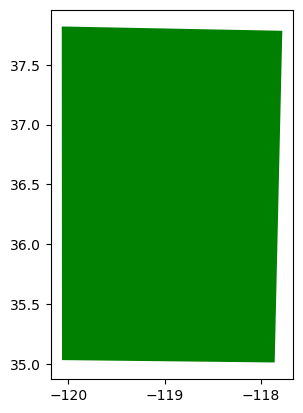

In [19]:
gdf.plot(color='green')

In [20]:
# filter if the API breaks
#gdf = gdf[599:]
#gdf

In [21]:
for index, row in gdf.iterrows():
    print(row['id'])

    end = row['SURVEY_YEA']
    start = end - 23

    start_date = str(start)+'-01-01'
    end_date = str(end)+'-12-31'

    print(f'start is {start_date} end is {end_date}')

1
start is 2000-01-01 end is 2023-12-31


In [22]:
for index, row in gdf.iterrows():
    print(row['id'])

    end = row['SURVEY_YEA']
    start = end - 2

    start_date = str(start)+'-01-01'
    end_date = str(end)+'-12-31'

    print(f'start is {start_date} end is {end_date}')

    corners = list(row['geometry'].exterior.coords)
    new_polygon = Polygon(corners)

    aoi  = ee.Geometry.Polygon([list(coord) for coord in corners])

    summer_collection = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filterBounds(aoi).filterDate(start_date, end_date).select('def')
    #summer_collection = pre_collection.filter(ee.Filter.calendarRange(6, 8, 'month'))
    image_list = summer_collection.toList(summer_collection.size())
    

    # create folder for images
    ads_id = row['id']
    folder_path  = './cwd/images/'+str(ads_id)
    print(folder_path)
    # create folders
    try:
        os.makedirs(folder_path)
    except:
        print('Folder in place already')
    # number of images in collection for aoi
    num_images = summer_collection.size().getInfo()
    for item in range(0, num_images):
        # take images
        filter_image = ee.Image(image_list.get(item))
        # clip to aoi
        pre_image = filter_image.clip(aoi)#.unmask()
        # image name
        im_name = str(pre_image.get('system:index').getInfo())
        print(im_name)
        # take url
        try:
            url = pre_image.getDownloadURL({'scale':4000,
                                                    'filePerBand':False, 
                                                    'region':aoi,
                                                    'crs':'EPSG:4326', 
                                                    'maxPixels': 1e13})
            #print(url)
            r = requests.get(url)
            with open(folder_path+'/'+im_name+'.zip', 'wb') as f:
                f.write(r.content)
        except:
            print('no images avialable')
            continue
        # extract the zipfile here
        zip_file = glob.glob('./cwd/images/'+str(ads_id)+'/*zip')
        try:
            zf = ZipFile(zip_file[0])
            zf.extractall('./cwd/images/'+str(ads_id))
            os.remove(zip_file[0])
        except BadZipfile:
            os.remove(zip_file[0])

    print('Down load succefull')

1
start is 2021-01-01 end is 2023-12-31
./cwd/images/1
202101
202102
202103
202104
202105
202106
202107
202108
202109
202110
202111
202112
202201
202202
202203
202204
202205
202206
202207
202208
202209
202210
202211
202212
202301
202302
202303
202304
202305
202306
202307
202308
202309
202310
202311
202312
Down load succefull
